# Imports and Paths

In [1]:
import os
# import pandas as pd
import sys
# import numpy as np
from sklearn.ensemble import *

In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
PATH_base = '/home/bj/git/data_science/'
PATH_bd = '/data/blue_book/'
PATH_func = PATH_base + 'src/'

In [3]:
if os.name == 'nt':
    PATH_base = 'E:\\GitHub\\data_science\\'
    PATH_bd = 'E:\\GitHub\\data_science\\data\\uncompressed\\blue_book_for_bulldozers\\'
    PATH_func = 'E:\\GitHub\\data_science\\src\\'
elif os.name == 'posix':
    PATH_base = '/home/msnow/git/data_science/'
    PATH_bd = '/data/msnow/data_science/blue_book_for_bulldozers/'
    PATH_func = PATH_base + 'src/'

In [6]:
sys.path.append(PATH_func)

In [124]:
from features.imports import *
from features.utilities import *
from features.fastai import *

In [10]:
%ls ..\\data\\uncompressed\\blue_book_for_bulldozers\\

 Volume in drive E is Storage
 Volume Serial Number is D098-4C8A

 Directory of E:\GitHub\data_science\data\uncompressed\blue_book_for_bulldozers

03/24/2018  04:37 PM    <DIR>          .
03/24/2018  04:37 PM    <DIR>          ..
01/24/2013  09:08 PM       116,403,970 Train.csv
01/24/2013  07:11 PM         3,318,969 Valid.csv
               2 File(s)    119,722,939 bytes
               2 Dir(s)  1,852,864,679,936 bytes free


# Initial Data Munging

This dataset is from the kaggle competition [Blue Book for Bulldozers](https://www.kaggle.com/c/bluebook-for-bulldozers).  

In [23]:
df_raw = pd.read_csv(f'{PATH_bd}Train.csv', low_memory=False, parse_dates=["saledate"],nrows=50000)

In [10]:
# df_raw.to_feather(f'{PATH_bd}bulldozer_raw')
# df_orig = df_raw.copy()
# df_raw = df_orig

In [11]:
display_some(df_raw.head().T,80,10)

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000,57000,10000,38500,11000
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


## Metrics

In this competition, the goal is to predict the SalePrice and the metric used is the root mean squared log error (RMSLE).  Therefore, I will convert the SalePrice column into the log of the SalePrice

In [24]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

## Splitting Datetime

Split the dattime column `saledate` into multiple columns containing integer components of the datetime, e.g., year, month, day, day of week, weekend

In [25]:
add_datepart(df_raw, 'saledate')

## Convert Strings to Integer Categorical 

Convert all columns with string values to integer categorical variables

In [26]:
train_cats(df_raw)

In [27]:
df_raw.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

When there is ordinality in the strings you can assign the categorical integer values to share that order

In [28]:
df_codes = df_raw.UsageBand.cat.codes
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

In [29]:
df_UsageBand_cat = pd.DataFrame({'Raw':df_raw.UsageBand, 'Unordered':df_codes, 'Ordered':df_raw.UsageBand.cat.codes})
df_UsageBand_cat.head()

,Ordered,Raw,Unordered
0,2,Low,1
1,2,Low,1
2,0,High,0
3,0,High,0
4,1,Medium,2


In [30]:
df, y, na_dict = proc_df(df_raw, 'SalePrice')

## Save to/Load from Feather

In [6]:
# df_raw.to_feather(f'{PATH_base}\\data\\interim\\bulldozer')
df_raw = pd.read_feather(f'{PATH_base}\\data\\interim\\bulldozer')

# Random Forest

## $r^2$ and RMSE

In [31]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df, y)

0.9824105402447549

This score is the $r^2$ which is defined as :

$$r^2 = 1-\dfrac{SS_{res}}{SS_{tot}}  = 1-\dfrac{\sum\limits_i\left(y_i-f_i\right)^2}{\sum\limits_i\left(y_i-\bar{y}\right)^2}$$

where $y_i$ is the true output, $f_i$ is the model output and $\bar{y}$ is the mean true output.  Intepretation of different $r^2$ values is as follows
  1. $r^2 = 1$ means that the model perfectly predicts the output
  1. $r^2 = 0$ means the model does no better than predicting the output using the mean output, i.e., $\bar{y}$
  1. $1 > r^2 > 0 $ means that the model is better than simply using the mean ouptut
  1. $r^2 < 0$ means that the model is worse than just using the mean output as a predictor
 
However, $r^2$ by itself, is not a good metric as an overfit model will have an $r^2$ close to 1 for the training set, but would do much worse on a test set. 

To overcome the issue of overfitting, we can split the data into a training and validation set; using the training set to build the model and the validation set to test how good the model does on a different set of data.

In [32]:
n_trn = len(df)-12000
X_train, X_valid = split_train_val(df,trn_amount=n_trn)
y_train, y_valid = split_train_val(y,trn_amount=n_trn)

X_train.shape, y_train.shape, X_valid.shape

((38000, 65), (38000,), (12000, 65))

In [33]:
train_rmse = custom_RFscore(m, X_train, y_train)
valid_rmse = custom_RFscore(m, X_valid, y_valid) 
train_score = m.score(X_train, y_train)
valid_score = m.score(X_valid, y_valid)
print(f'Training rmse: {train_rmse}')
print(f'Validation rmse: {valid_rmse}')
print(f'Training Score: {train_score}')
print(f'Validation Score: {valid_score}')

Training rmse: 0.09349769556571906
Validation rmse: 0.0688803687875353
Training Score: 0.9834323702372217
Validation Score: 0.9718148732063945


## Speeding Things Up

In [34]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=na_dict)
X_train, _ = split_train_val(df_trn, trn_amount=20000)
y_train, _ = split_train_val(y_trn, trn_amount=20000)

In [35]:
m = RandomForestRegressor(n_jobs=-1);
m.fit(X_train, y_train);

In [36]:
train_rmse = custom_RFscore(m, X_train, y_train)
valid_rmse = custom_RFscore(m, X_valid, y_valid) 
train_score = m.score(X_train, y_train)
valid_score = m.score(X_valid, y_valid)
print(f'Training rmse: {train_rmse}')
print(f'Validation rmse: {valid_rmse}')
print(f'Training Score: {train_score}')
print(f'Validation Score: {valid_score}')

Training rmse: 0.09821146385156575
Validation rmse: 0.1408816580112238
Training Score: 0.9781615564366094
Validation Score: 0.8820934386314245


In [37]:
def print_custom_RFscore():
    train_rmse = custom_RFscore(m, X_train, y_train)
    valid_rmse = custom_RFscore(m, X_valid, y_valid) 
    train_score = m.score(X_train, y_train)
    valid_score = m.score(X_valid, y_valid)
    print(f'Training rmse: {train_rmse}')
    print(f'Validation rmse: {valid_rmse}')
    print(f'Training Score: {train_score}')
    print(f'Validation Score: {valid_score}')

## Single Tree

In [4]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_custom_RFscore()

Training rmse: 0.5392840105293845
Validation rmse: 0.5794726966342749
Training Score: 0.40094421266106184
Validation Score: 0.4003277810486982


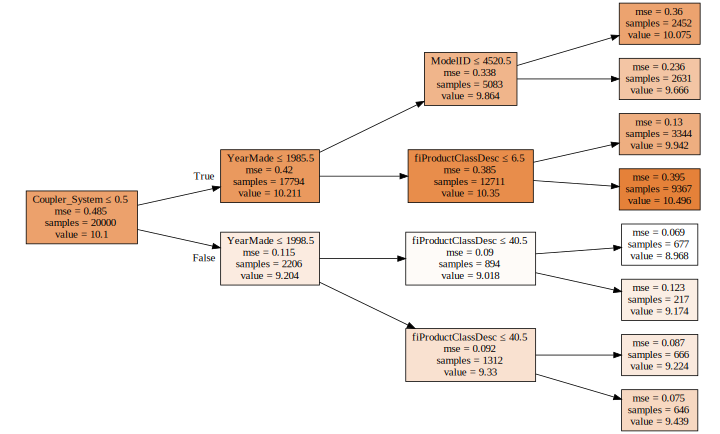

In [5]:
draw_tree(m.estimators_[0], df_trn, precision=3)

### Interpreting the Decision Tree

If I took the mean output of my entire dataset and used that to predict the output for each individual observation, what would the mean square error be?

In [40]:
mse = ((y_train - y_train.mean())**2).mean()
print(f'mean square error = {round(mse,3)}')
print(f'samples = {len(y_train)}')
print(f'mean value = {round(y_train.mean(),3)}')

mean square error = 0.442
samples = 20000
mean value = 9.941


Taking a look at the tree above, we can now see that the `values` and `mse` term of the first box correspond to the mean output value and mean squared error using the output value of the entire dataset. Let's see if this analysis holds true for the next couple of boxes.

In [41]:
y_train_2_1 = y_train[list(X_train.Coupler_System <= 0.5)]
mse = ((y_train_2_1 - y_train_2_1.mean())**2).mean()
print(f'mean square error = {round(mse,3)}')
print(f'samples = {len(y_train_2_1)}')
print(f'mean value = {round(y_train_2_1.mean(),3)}')

mean square error = 0.386
samples = 16380
mean value = 10.093


In [42]:
y_train_2_2 = y_train[list(X_train.Coupler_System > 0.5 )]
mse = ((y_train_2_2 - y_train_2_2.mean())**2).mean()
print(f'mean square error = {round(mse,3)}')
print(f'samples = {len(y_train_2_2)}')
print(f'mean value = {round(y_train_2_2.mean(),3)}')

mean square error = 0.113
samples = 3620
mean value = 9.252


In [43]:
y_train_3_1 = y_train[list((X_train.Coupler_System <= 0.5)  & (X_train.YearMade <= 1991.5))]
mse = ((y_train_3_1 - y_train_3_1.mean())**2).mean()
print(f'mean square error = {round(mse,3)}')
print(f'samples = {len(y_train_3_1)}')
print(f'mean value = {round(y_train_3_1.mean(),3)}')

mean square error = 0.254
samples = 6749
mean value = 9.737


# RERUNNING

In [1]:
import os
import sys
from sklearn.ensemble import *
%load_ext autoreload
%autoreload 2
if os.name == 'nt':
    PATH_base = 'E:\\GitHub\\data_science\\'
    PATH_bd = 'E:\\GitHub\\data_science\\data\\uncompressed\\blue_book_for_bulldozers\\'
    PATH_func = 'E:\\GitHub\\data_science\\src\\'
elif os.name == 'posix':
    PATH_base = '/home/msnow/git/data_science/'
    PATH_bd = '/data/msnow/data_science/blue_book_for_bulldozers/'
    PATH_func = PATH_base + 'src/'
sys.path.append(PATH_func)
from features.imports import *
from features.utilities import *
from features.fastai import *

In [2]:
df_raw = pd.read_feather(f'{PATH_base}\\data\\interim\\bulldozer')
df, y, na_dict = proc_df(df_raw, 'SalePrice')

In [104]:
n_trn = len(df)-12000
_, X_valid = split_train_val(df,trn_amount=n_trn)
_, y_valid = split_train_val(y,trn_amount=n_trn)
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=na_dict)
X_train, _ = split_train_val(df_trn, trn_amount=20000)
y_train, _ = split_train_val(y_trn, trn_amount=20000)
m = RandomForestRegressor(n_jobs=-1);
m.fit(X_train, y_train);
def print_custom_RFscore():
    train_rmse = custom_RFscore(m, X_train, y_train)
    valid_rmse = custom_RFscore(m, X_valid, y_valid) 
    train_score = m.score(X_train, y_train)
    valid_score = m.score(X_valid, y_valid)
    print(f'Training rmse: {train_rmse}')
    print(f'Validation rmse: {valid_rmse}')
    print(f'Training Score: {train_score}')
    print(f'Validation Score: {valid_score}')
    if hasattr(m, 'oob_score_'):
        print(f'OOB Score: {m.oob_score_}')

## Bagging

The problem with using a single tree is that the smaller the leaf nodes are, the more overfit the model is.  When the leaf nodes only have a single value in them, the model is perfectly predicts the training set but does not score nearly as high on the validation set

In [46]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_custom_RFscore()

Training rmse: 2.3874896000997127e-06
Validation rmse: 0.17997538860410744
Training Score: 0.9999999999870944
Validation Score: 0.8075777425128688


### Bagging Tutorial

To go from single decision trees to a random forest, you want to somehow combine multiple decision trees to end up with a result that is somehow better than any single decision tree.  This act of combining models to get a better model is called ensembling.  For the random forest, the idea being that you create lots of "bad" decision trees, where each one does contain some insight about your data as well as significantly overfitting the data (high score on training set, low score on validation set).  If you repeat this with lots of uncorrelated trees then their overfitting errors, which are randomly distributed, should average to zero, while retaining each individual tree's true information.

To uncorrelate the data we can randomly choose a subset of the data for each decision tree.

Lucky for us this is what scikit-learn does by default (this is the bootstrap parameter in the RandomForestRegressor (RFR)).  Technically, the RFR, picks out n_rows with replacement.

In [6]:
m = RandomForestRegressor(n_estimators=3, max_depth=2, bootstrap=True, n_jobs=-1, max_features=0.5)
m.fit(X_train, y_train);

In [36]:
X_samp = X_valid.sample(3)
preds = np.stack([t.predict(X_samp) for t in m.estimators_])

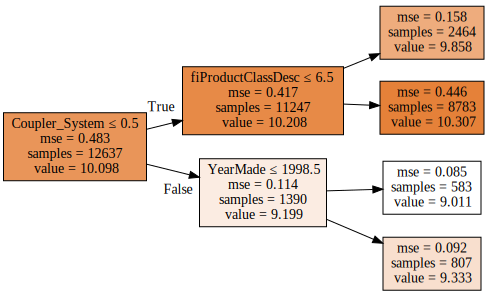

In [41]:
draw_tree(m.estimators_[0], df_trn, precision=3)

In [42]:
tree = m.estimators_[0].tree_
tree_features = X_train.columns[tree.feature[tree.feature>0]].tolist()
X_pred0 = X_samp[tree_features].copy()
X_pred0['prediction'] = np.round(preds[0,:],3)
X_pred0

,Coupler_System,fiProductClassDesc,YearMade,prediction
393484,0,49,1989,10.307
390375,1,41,2005,9.333
399437,0,14,1000,10.307


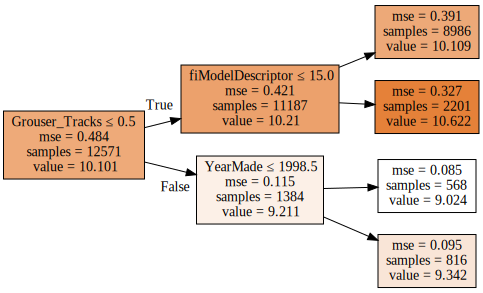

In [43]:
draw_tree(m.estimators_[1], df_trn, precision=3)

In [44]:
tree = m.estimators_[1].tree_
tree_features = X_train.columns[tree.feature[tree.feature>0]].tolist()
X_pred1 = X_samp[tree_features].copy()
X_pred1['prediction'] = np.round(preds[1,:],3)
X_pred1

,Grouser_Tracks,fiModelDescriptor,YearMade,prediction
393484,0,71,1989,10.622
390375,2,0,2005,9.342
399437,0,20,1000,10.622


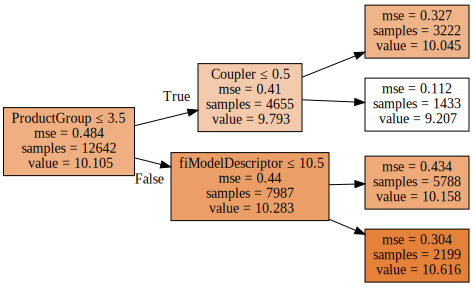

In [45]:
draw_tree(m.estimators_[2], df_trn, precision=3)

In [46]:
tree = m.estimators_[2].tree_
tree_features = X_train.columns[tree.feature[tree.feature>0]].tolist()
X_pred2 = X_samp[tree_features].copy()
X_pred2['prediction'] = np.round(preds[2,:],3)
X_pred2

,ProductGroup,Coupler,fiModelDescriptor,prediction
393484,5,0,71,10.616
390375,3,3,0,9.207
399437,4,3,20,10.616


Comparing the average prediction for each sample to the output of the predict function gives the same result.  This demonstrates how the random forest computes the prediction for each sample.

In [50]:
print(f'Average prediction: {np.mean(preds,axis=0)}')
print(f'predict function: {m.predict(X_samp)}')

Average prediction: [10.51478961  9.29399394 10.51478961]
predict function: [10.51478961  9.29399394 10.51478961]


Since the errors are randomly distributed, in theory, the predictions from the trees should form a normal distribution.

In [93]:
m = RandomForestRegressor(n_estimators=1000, bootstrap=True, n_jobs=-1, max_features=0.5)
m.fit(X_train, y_train);
X_samp = X_valid.sample(1)
preds = np.stack([t.predict(X_samp) for t in m.estimators_])

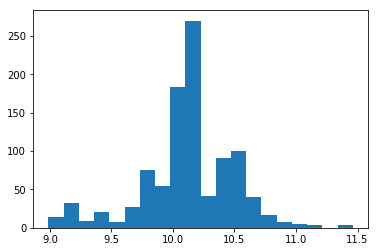

In [97]:
plt.hist(preds, bins=20);

### Implementing Bagging

Starting with the basic model

In [51]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_custom_RFscore()

Training rmse: 0.11667995856565676
Validation rmse: 0.2869778625125253
Training Score: 0.9719569844490079
Validation Score: 0.8529229985551873


In [62]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])

We can demonstrate how the predictive ability of the RF model increases with the number of ensembled decision trees

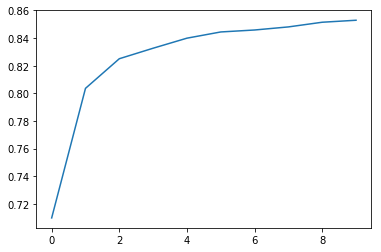

In [64]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

Let's see how the validation score improves as a function of the number of tree

In [101]:
m = RandomForestRegressor(n_jobs=-1,n_estimators=10)
m.fit(X_train, y_train)
print_custom_RFscore()

Training rmse: 0.11691499918113024
Validation rmse: 0.2812932565924041
Training Score: 0.9718438907106337
Validation Score: 0.8586920434907607


In [98]:
m = RandomForestRegressor(n_jobs=-1,n_estimators=20)
m.fit(X_train, y_train)
print_custom_RFscore()

Training rmse: 0.1080910718330679
Validation rmse: 0.27643686348845103
Training Score: 0.9759335614124797
Validation Score: 0.8635291528569986


In [99]:
m = RandomForestRegressor(n_jobs=-1,n_estimators=40)
m.fit(X_train, y_train)
print_custom_RFscore()

Training rmse: 0.10150961937253764
Validation rmse: 0.27146211215209665
Training Score: 0.9787750547329871
Validation Score: 0.8683968084199611


In [100]:
m = RandomForestRegressor(n_jobs=-1,n_estimators=80)
m.fit(X_train, y_train)
print_custom_RFscore()

Training rmse: 0.09827296154985389
Validation rmse: 0.27020073279601015
Training Score: 0.980107000641755
Validation Score: 0.869616985153063


You can see that the validation score does improve, but there is diminishing returns

### Out-of-Bag (OOB) score 

You can see in the cases above that even with the bagging and increasing the number of trees, the validation score is still significantly lower than the training score.  This often means that we are overfitting the model.  But maybe the validation set is just statistically different than the training set, in which case the validation score will always be lower.  To test this possibility we can do something call Out-of-Bagging (OOB).  

When using bagging, we are only selecting n-rows for each tree.  For example, if there are 20 trees built, row 1 could be used only in trees 1, 7, 13, and 15.  If that's the case, then tree 2 was not trained using row 1 and so it can be used as a validation set for tree 2.  This is what OOB does, it uses each row as part of the validation set, but only for the trees which did not use it to train.  Since the OOB validation set comes from same data as the training set, any difference is scores is due to overfitting and not statistically distinct sets.

In [110]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train);
print_custom_RFscore()

Training rmse: 0.10155569125594387
Validation rmse: 0.26677607867147174
Training Score: 0.97851026448116
Validation Score: 0.8729011142596962
OOB Score: 0.847722291172098


Practically, the oob score slightly underestimates the generalizability of the model, but this decreases as a function of the number of samples.

In this case you can see that the oob score is very similar to the validation score, which confirms that the drop in score is most probably due to overfitting and not different distributions.

## Reducing Overfitting

### Subsampling

To make the random forest faster, I subsampled from the original dataset 20,000 rows, and then built all of my decision trees, with boostrapping and oob_score, on those subset of rows.  An alternative is to build each tree from a sample of 20,000 rows, from my entire dataset, for each tree.  This allows you to take advantage of a faster model (less samples) while accessing a larger training and validation set.

In [116]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_train_val(df_trn, n_trn)
y_train, y_valid = split_train_val(y_trn, n_trn)

In [122]:
set_rf_samples(20000)

In [120]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_custom_RFscore()

Training rmse: 0.24126072065343024
Validation rmse: 0.2767189887773357
Training Score: 0.8783511332334722
Validation Score: 0.8632504525146026
OOB Score: 0.8656224989110298


In [121]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True, n_estimators=40)
m.fit(X_train, y_train)
print_custom_RFscore()

Training rmse: 0.22731397154924346
Validation rmse: 0.2618011618093503
Training Score: 0.8920091185938114
Validation Score: 0.8775972675089081
OOB Score: 0.8804921832235565


Now you can see that while our validation and oob_scores have not improved, the training score has decreased.  While this might seem like a bad thing, what this implies is that now, we are no longer ovrefitting the model.

Be aware that currently, the oob score still only looks at the unused rows of the sample set, not the entire dataset.

### Tree Building Parameters

We revert to using a full bootstrap sample in order to show the impact of other over-fitting avoidance methods.

In [125]:
reset_rf_samples()

In [130]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_custom_RFscore()

Training rmse: 0.0783123950644594
Validation rmse: 0.23699000175463975
Training Score: 0.987182720971379
Validation Score: 0.8996983627129161
OOB Score: 0.9086158701976964


Another way to reduce over-fitting is to grow our trees less deeply. We do this by specifying (with min_samples_leaf) that we require some minimum number of rows in every leaf node. This has two benefits:

 - There are less decision rules for each leaf node; simpler models should generalize better
 - The predictions are made by averaging more rows in the leaf node, resulting in less volatility

In [132]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_custom_RFscore()

Training rmse: 0.11511535517453375
Validation rmse: 0.2360507832161104
Training Score: 0.9723050017727247
Validation Score: 0.9004918011159826
OOB Score: 0.9085097009274974


We can also increase the amount of variation amongst the trees by not only use a sample of rows for each tree, but to also using a sample of columns for each split. We do this by specifying max_features, which is the proportion of features to randomly select from at each split.

 - None
 - 0.5
 - 'sqrt'
 - An integer value, e.g., 1, 3, 5

In [131]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_custom_RFscore() 

Training rmse: 0.11902840748625773
Validation rmse: 0.2280451534681458
Training Score: 0.9703901592068734
Validation Score: 0.9071269586823107
OOB Score: 0.9118430414192688
